# Natural Selection Forward Simulation

There are two main approaches in simulating the selective advantage of the F508del-CFTR mutation: backward-time (coalescent) and forward-time simulations. This notebook uses the [simuPOP](http://simupop.sourceforge.net/) program, described in [Peng et al. 2007](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.0030047).


As a simple model, I have taken the [Natural selection](http://simupop.sourceforge.net/manual_svn/build/userGuide_ch5_sec9.html_) model from the simuPOP user guide. This models natural selection through the selection of parents. It assigns each individual a fitness value, dependent on their genotype. When mating happens, parents are chosen with probabilities that are proportional to their fitness values.

Fitness values are assigned as follows: 
* 1-$s_2$ for homozygous F508del-CFTR
* 1 to heterozygous F508del-CFTR
* 1-$s_1$ to Wild type. 

A Random mating scheme is used (i.e. anyone can mate with anyone). More advanced mating schemes can be implemented to simulate sub groups mixing over a certian number of generations. The population is also kept constant (at around 10000) but this can be made more complex to model population growth.

In [1]:
#Import modules
import simuPOP as sim
import numpy as np
import pylab as plt
%matplotlib inline

simuPOP Version 1.1.6 : Copyright (c) 2004-2011 Bo Peng
Revision 4972 (Sep 10 2015) for Python 2.7.6 (64bit, 0thread)
Random Number Generator is set to mt19937 with random seed 0xd92532944e1ed9f1.
This is the standard short allele version with 256 maximum allelic states.
For more information, please visit http://simupop.sourceforge.net,
or email simupop-list@lists.sourceforge.net (subscription required).


For this simulation, I set $s_1$ to 0.05, giving a slight disadvantage to wildtype over hetrozygous individuals, $s_2$ to 1, i.e. none survive to mate. I run the simulation for 500 generations, with population of 10000 individuals. I repeat the simulation 10 times, and set the initial frequency of F508del-CFTR allele to 0.002, the estimated level before F508del-CFTR became extremely advantagous for the European population [Modiano et al. 2007](http://www.nature.com/ejhg/journal/v15/n3/abs/5201749a.html)

In [2]:
#set up parameters
s1 = .05 # selective advantage of wildtype
s2 = 1  # selective advantage of homozygous F508del-CFTR
initial_pop=10000.0
generations =500 # number of generations to evolve model over
reps=10
freqs=[] #list to store frequency of allele in population
initial_freq=0.002

In [3]:
#Set up model
pop = sim.Population(initial_pop, loci=1,infoFields='fitness')
simu = sim.Simulator(pop, rep=reps)

#set up function that stores frequency of allele in population
def func(msg):
    freqs.append(float(msg))
    

In [4]:
#Evolve simulation over 
x=simu.evolve(
    initOps=[
        sim.InitSex(),
        sim.InitGenotype(freq=[1.0-initial_freq, initial_freq])
    ],
    preOps=sim.MapSelector(loci=0, fitness={(0,0):1-s1, (0,1):1, (1,1):1-s2}),
    matingScheme=sim.RandomMating(),
    postOps=[
        sim.Stat(alleleFreq=0, step=1),
        sim.PyEval(r"'%.3f\t' % alleleFreq[0][1]", step=10, output=func)
    ],
    gen = generations
)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


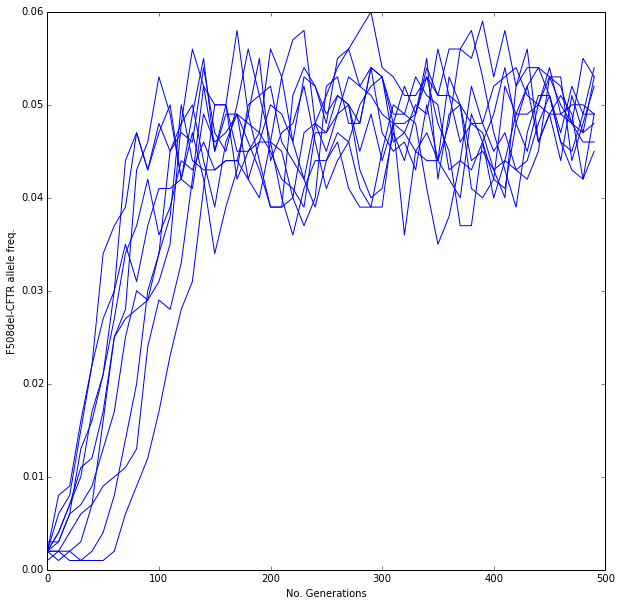

In [5]:
import pylab as plt
%matplotlib inline
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(0,reps):
    ax.plot(np.arange(0,generations,reps),np.array(freqs)[i:(generations*float(reps))+i:reps], 'b-')
ax.set_xlabel('No. Generations')
ax.set_ylabel('F508del-CFTR allele freq.')
freqs_orig=freqs

I can change the selective advantage and see how it changes the allele frequency across generations.

In [6]:
#set up parameters
s1 = .02 # selective advantage of wildtype
s2 = 1  # selective advantage of homozygous F508del-CFTR
initial_pop=10000.0
generations =500 # number of generations to evolve model over
reps=10
freqs=[] #list to store frequency of allele in population
initial_freq=0.002

In [7]:
#set up parameters
s1 = .05 # selective advantage of wildtype
s2 = 1  # selective advantage of homozygous F508del-CFTR
initial_pop=1000.0
generations =500 # number of generations to evolve model over
reps=10
freqs=[] #list to store frequency of allele in population
initial_freq=0.002

In [8]:
#Set up model
pop = sim.Population(initial_pop, loci=1,infoFields='fitness')
simu = sim.Simulator(pop, rep=reps)

#set up function that stores frequency of allele in population
def func(msg):
    freqs.append(float(msg))
    

In [9]:
#Evolve simulation over 
x=simu.evolve(
    initOps=[
        sim.InitSex(),
        sim.InitGenotype(freq=[1.0-initial_freq, initial_freq])
    ],
    preOps=sim.MapSelector(loci=0, fitness={(0,0):1-s1, (0,1):1, (1,1):1-s2}),
    matingScheme=sim.RandomMating(),
    postOps=[
        sim.Stat(alleleFreq=0, step=1),
        sim.PyEval(r"'%.3f\t' % alleleFreq[0][1]", step=10, output=func)
    ],
    gen = generations
)

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:4: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:5: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


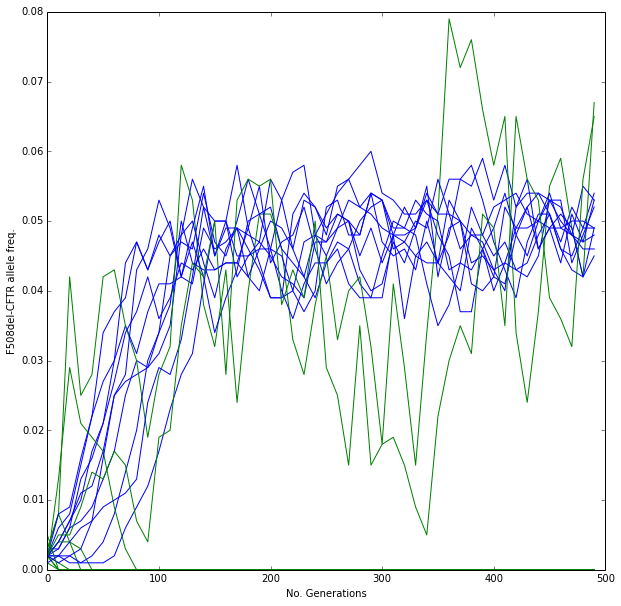

In [10]:
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
for i in range(0,reps):
    ax.plot(np.arange(0,generations,reps),np.array(freqs_orig)[i:(generations*float(reps))+i:reps], 'b-')
    ax.plot(np.arange(0,generations,reps),np.array(freqs)[i:(generations*float(reps))+i:reps], 'g-')
ax.set_xlabel('No. Generations')
ax.set_ylabel('F508del-CFTR allele freq.')

I can carry out Bayesian inference using MCMC, to find the likely values of $s_1$, given the initial frequency of the F508del-CFTR allele and the known value today. We should probably finalise the model first (i.e. are we happy with constant population? Is random mating appropriate? etc)

# Bayesian Inference with [emcee](http://dan.iel.fm/emcee/current/)

In [11]:
import numpy as np
import emcee

In [12]:
def lnprior(x):
    if 0.0 < x < 0.1:
        return 0.0
    return -np.inf

In [13]:
def lnprob(x, final_freq):
    lp = lnprior(x)
    if not np.isfinite(lp):
        return -np.inf
    #set up parameters
    s1 = x[0] # selective advantage of wildtype
    s2 = 1  # selective advantage of homozygous F508del-CFTR
    initial_pop=5000.0
    generations =250 # number of generations to evolve model over
    reps=10
    freqs=[] #list to store frequency of allele in population
    initial_freq=0.002
    #Set up model
    pop = sim.Population(initial_pop, loci=1,infoFields='fitness')
    simu = sim.Simulator(pop, rep=reps)

    #set up function that stores frequency of allele in population
    def func(msg):
        freqs.append(float(msg))
    #Evolve simulation over 
    x=simu.evolve(
    initOps=[
        sim.InitSex(),
        sim.InitGenotype(freq=[1.0-initial_freq, initial_freq])
    ],
    preOps=sim.MapSelector(loci=0, fitness={(0,0):1-s1, (0,1):1, (1,1):1-s2}),
    matingScheme=sim.RandomMating(),
    postOps=[
        sim.Stat(alleleFreq=0, step=1),
        sim.PyEval(r"'%.3f\t' % alleleFreq[0][1]", step=reps, output=func)
    ],
    gen = generations
    )
    final_gen=np.array(freqs)[-1:-1-float(reps):-1]
    log_like=-0.5*((np.mean(final_gen)-final_freq)/0.01)**2
    return log_like+lp

In [14]:
nwalkers = 4
ndim=1
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers,ndim))*0.1
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[1/25.0])


In [15]:
pos, prob, state = sampler.run_mcmc(p0, 100)
sampler.reset()

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [ ]:
print p0

[[ 0.08710491]
 [ 0.08102003]
 [ 0.02060332]
 [ 0.01967766]]


In [ ]:
sampler.run_mcmc(pos, 1000)
